In [1]:
import sys
sys.path.append('..')

# Deep Learning
import torch
from torch import nn

# Data Utils
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model parameters
Models with the following parameters have been pre-trained. We re-define their parameters here so that we can initialize and load the state dicts of each model. 

In [2]:
# AD window:
window = 7

# Dense model params
hidden = (100, 50, 20, 50, 100)
d_lr = 1e-6

# LSTM model params
n_features = 1
emb_size = 70
l_lr=1e-4

## Load the dataset

<AxesSubplot:>

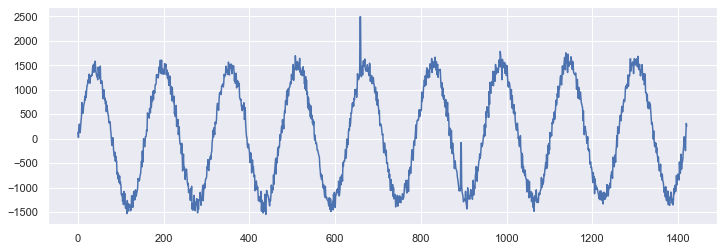

In [3]:
synth_df = pd.read_csv('data/synthetic_10.txt')
synth_tensor = torch.tensor(synth_df.value)
sns.lineplot(data=synth_tensor)

## Preprocess for ML

In [4]:
# Chunk series into 7 day subsequences and apply difference transform.
transform = preprocess.Difference()

seqs = preprocess.sequence(synth_tensor, window)
seqs = torch.stack([transform(s) for s in seqs])

## Load pre-trained models

In [5]:
lstm = networks.LSTMEncoderDecoder(n_features, emb_size)
lstm.load_state_dict(torch.load(f'models/lstm_model_size={emb_size}_lr={l_lr}.pt'))

dense = networks.FCNetwork(window, hidden, window)
dense.load_state_dict(torch.load(f'models/dense_lr={d_lr}_{hidden}.pt'))

<All keys matched successfully>

## Dense Inference

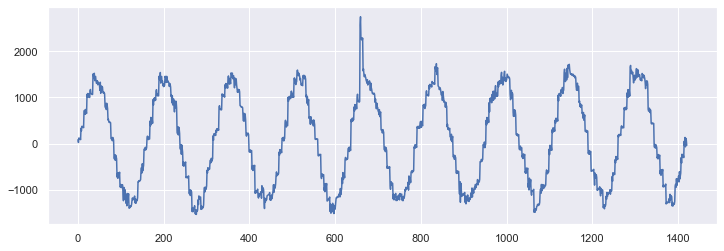

In [6]:
with torch.no_grad():
    dense_results = dense(seqs)
    dense_results = [transform.inverse(x) for x in dense_results]
    dense_results = torch.cat(tuple(dense_results))
plt.plot(dense_results);

## LSTM Inference

In [7]:
# Run inference on all data.
lstm_results = torch.tensor([])
for s in seqs:
    x = s.unsqueeze(0).unsqueeze(-1).float()
    with torch.no_grad():
        x_hat = lstm(x)
        lstm_results = torch.cat((lstm_results, x_hat))

lstm_results = [transform.inverse(s) for s in lstm_results]
lstm_results = torch.cat(tuple(lstm_results)).view(-1)

## Weighted Average of Models

In [8]:
alpha = 0.2
beta = 0.8
final = alpha * dense_results + beta * lstm_results

## Get Anomaly Scores

<AxesSubplot:ylabel='Density'>

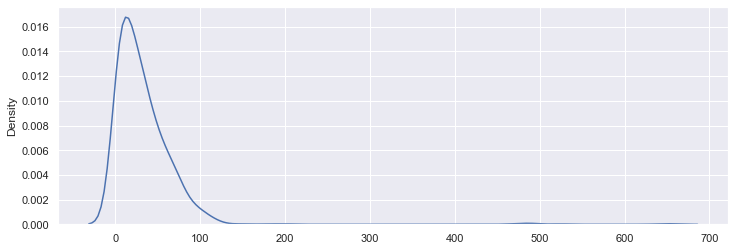

In [23]:
# Get L1 Loss of whole data set.
criterion = nn.L1Loss(reduction='none')
loss = criterion(final, synth_tensor)
sns.kdeplot(data=loss);

In [27]:
# get zscores 
scores = stats.zscore(loss)

# Build cumulative density function of scores
cdf = ECDF(scores.squeeze())

# Get threshold
thresh = next(x for x in scores if cdf(x) > 0.997)

# get x, y coordinates for plotting anoms.
x = np.where(scores > thresh)[0]
y = scores[scores > thresh]

## Visualize Anomalies

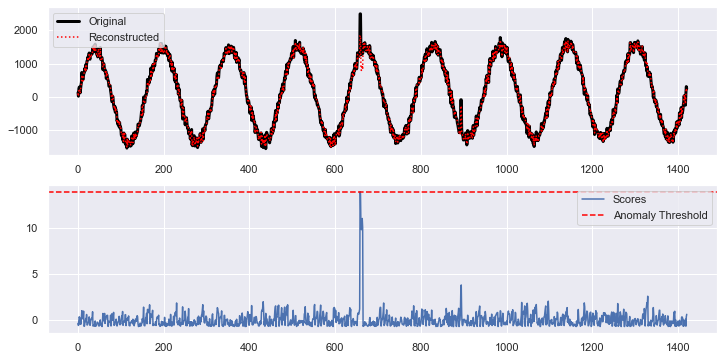

In [28]:
fig, ax, = plt.subplots(2, 1, sharex=False, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=synth_tensor, color='black', linestyle='-', linewidth=3, ax=ax[0], label="Original")
sns.lineplot(data=final, color='red', linestyle=':', ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=scores, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()